# E-tivity 4: Classification
## Collin Wyer (14103001)

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt

In [2]:
# Style plot
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

## Load dataset

In [3]:
df = pd.read_csv("./seeds.csv")

## EDA

In [4]:
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [5]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

We can see there are no nulls/NaNs. So now we can determine the existance of outliers using boxplots.

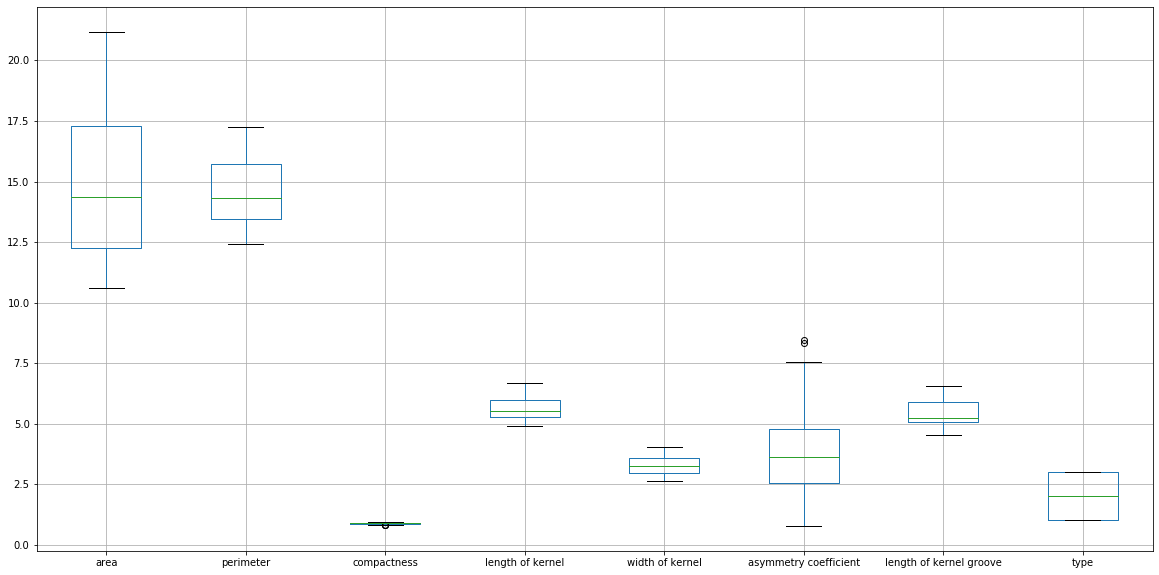

In [6]:
df.loc[:,'area':'type'].boxplot(figsize=(20,10))
plt.show()

As we can see, `asymmetry coefficient` & `compactness` have the only outliers and so we will apply log trans followed by RobustScaler to them, although neither are significant. The StandardScaler will be applied to the rest. 

### Visualize Features:

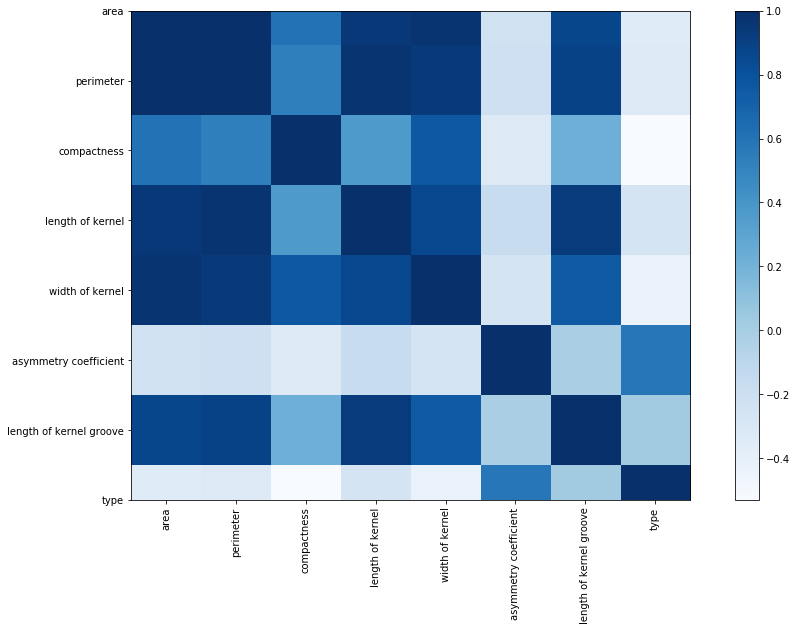

In [7]:
plt.imshow(df.corr(), cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df.columns))]
plt.xticks(tick_marks, df.columns, rotation='vertical')
plt.yticks(tick_marks, df.columns)

plt.show()

We can see from the correaltion heat map that `asymmetry coefficient` is the least correlated with any features, with `area` and `perimeter` the most correlated.

Using pair plots we can easily distinguish the 3 types of seeds and some of their defining features.

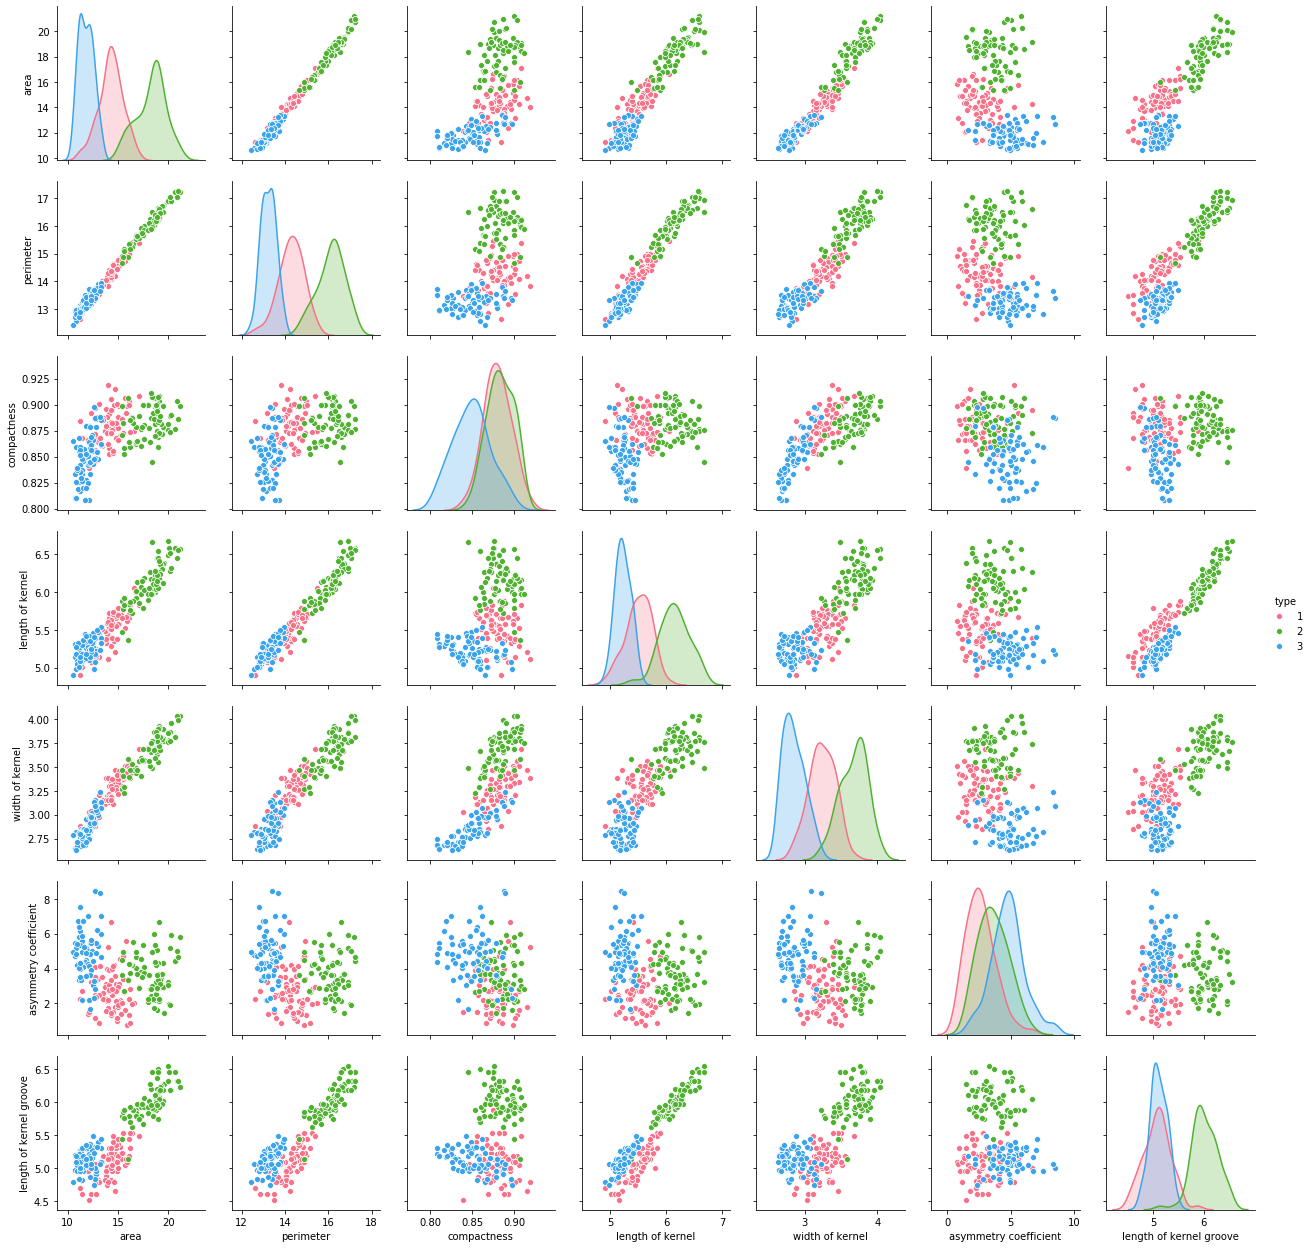

In [10]:
pplot = sns.pairplot(df, vars = ['area', 'perimeter', 'compactness', 'length of kernel', 'width of kernel', 'asymmetry coefficient', 'length of kernel groove'] ,hue='type', palette='husl')
plt.show()

To further visulaize the features of each type of seed we can use the boxplots.

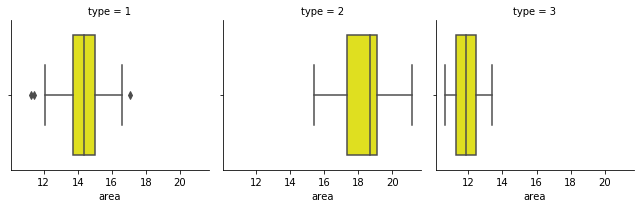

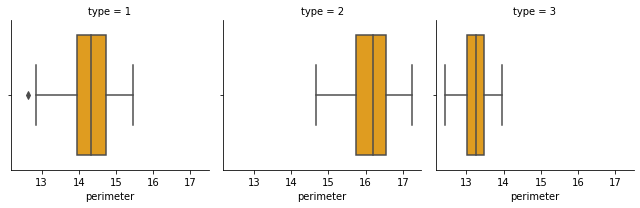

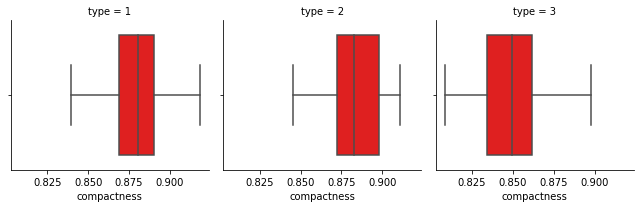

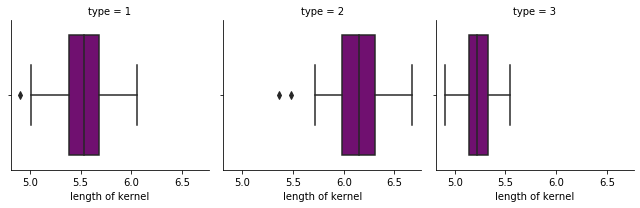

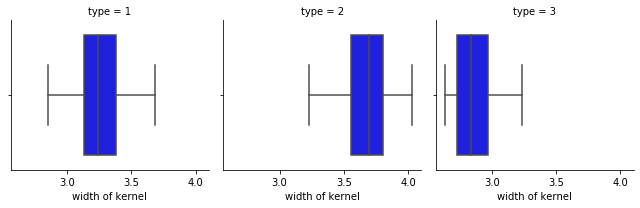

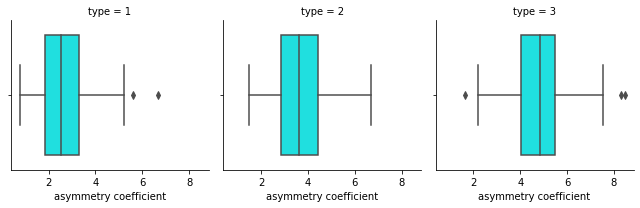

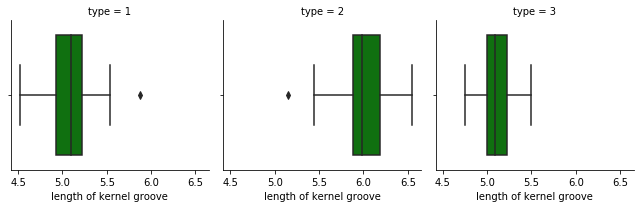

In [11]:
a = sns.FacetGrid(df, col='type')
a.map(sns.boxplot, 'area', color='yellow', order=['0', '1', '2'])

p = sns.FacetGrid(df, col='type')
p.map(sns.boxplot, 'perimeter', color='orange', order=['0', '1', '2'])

c = sns.FacetGrid(df, col='type')
c.map(sns.boxplot, 'compactness', color='red', order=['0', '1', '2'])

lk = sns.FacetGrid(df, col='type')
lk.map(sns.boxplot, 'length of kernel', color='purple', order=['0', '1', '2'])

wk = sns.FacetGrid(df, col='type')
wk.map(sns.boxplot, 'width of kernel', color='blue', order=['0', '1', '2'])

acoef = sns.FacetGrid(df, col='type')
acoef.map(sns.boxplot, 'asymmetry coefficient', color='cyan', order=['0', '1', '2'])

lkg = sns.FacetGrid(df, col='type')
lkg.map(sns.boxplot, 'length of kernel groove', color='green', order=['0', '1', '2'])

Using `asymmetry coefficient` as an example: we can see that a seed with a value between ~ 1.9 and 3.5 belongs to type 1. A value of ~ 3 to 4.5 belongs to type 2 and, a value of ~ 4 to 5.5 belongs to type 3. We can also see that type 1 and type 3 contain the outliers.
(NOTE: I'm not entirely sure why outliers are showing up in the above boxplots)

Using boxplots for both features we can easily identify the outliers. 

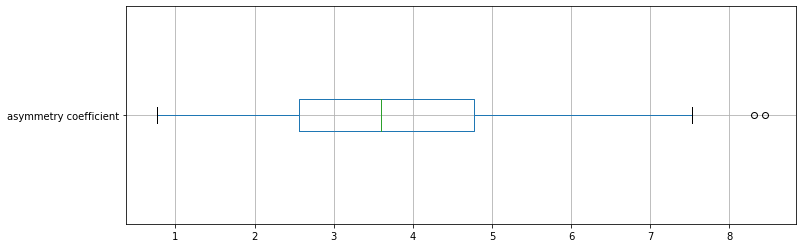

In [12]:
df.boxplot(column='asymmetry coefficient', figsize = (12,4), vert=False)
plt.show()

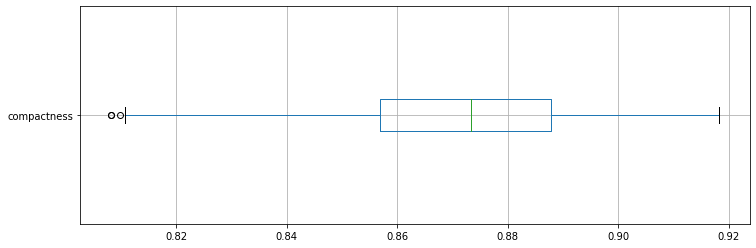

In [13]:
df.boxplot(column='compactness',figsize = (12,4), vert=False)
plt.show()

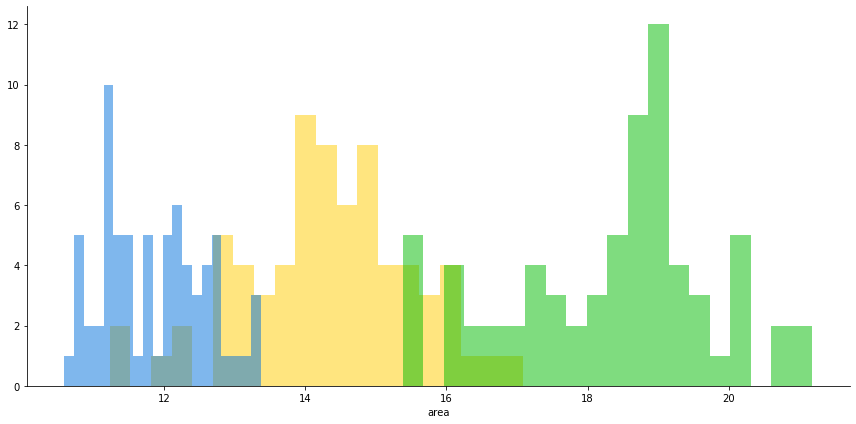

In [14]:
g = sns.FacetGrid(data=df, hue = 'type', palette = 'nipy_spectral_r', height = 6, aspect = 2)
g = g.map(plt.hist,'area', bins=20, alpha=0.5)
plt.show()

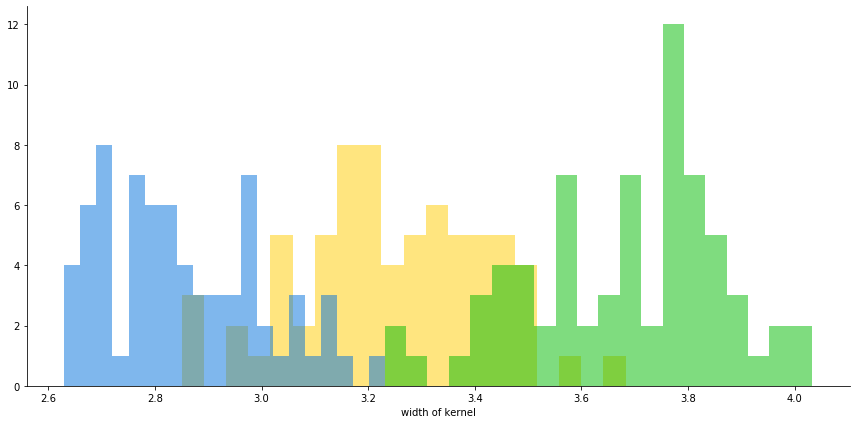

In [15]:
g = sns.FacetGrid(data=df, hue = 'type', palette = 'nipy_spectral_r', height = 6, aspect = 2)
g = g.map(plt.hist,'width of kernel', bins=20, alpha=0.5)
plt.show()

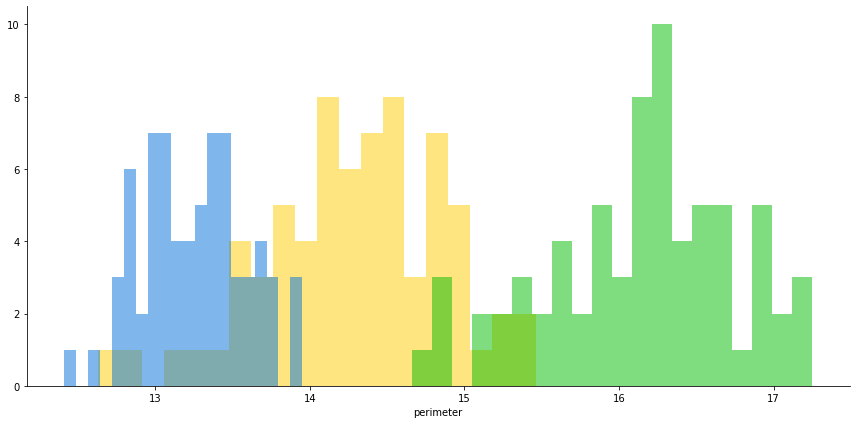

In [16]:
g = sns.FacetGrid(data=df, hue = 'type', palette = 'nipy_spectral_r', height = 6, aspect = 2)
g = g.map(plt.hist,'perimeter', bins=20, alpha=0.5)
plt.show()

It appears from the above visualizatios that, type 1 (yellow) and type 3 (blue) are most similar to each other. This can also be seen in the seed `type` statistics, below. Type 1 & Type 3 are more closely related than type 2.
#### It is for this reason that Type 1 & 3 will be combined.

In [17]:
 df.groupby('type').describe().T

type                                   1          2          3
area                    count  70.000000  70.000000  70.000000
                        mean   14.334429  18.334286  11.873857
                        std     1.215704   1.439496   0.723004
                        min    11.230000  15.380000  10.590000
                        25%    13.750000  17.330000  11.262500
                        50%    14.355000  18.720000  11.835000
                        75%    15.045000  19.137500  12.425000
                        max    17.080000  21.180000  13.370000
perimeter               count  70.000000  70.000000  70.000000
                        mean   14.294286  16.135714  13.247857
                        std     0.576583   0.616995   0.340196
                        min    12.630000  14.660000  12.410000
                        25%    13.960000  15.737500  13.002500
                        50%    14.320000  16.210000  13.250000
                        75%    14.732500  16.557500  13.470000
                        max    15.460000  17.250000  13.950000
compactness             count  70.000000  70.000000  70.000000
                        mean    0.880070   0.883517   0.849409
                        std     0.016191   0.015500   0.021760
                        min     0.839200   0.845200   0.808100
                        25%     0.868850   0.872525   0.834000
                        50%     0.880500   0.882600   0.849350
                        75%     0.890400   0.898225   0.861825
                        max     0.918300   0.910800   0.897700
length of kernel        count  70.000000  70.000000  70.000000
                        mean    5.508057   6.148029   5.229514
                        std     0.231508   0.268191   0.138015
                        min     4.902000   5.363000   4.899000
                        25%     5.384500   5.979250   5.136250
                        50%     5.534000   6.148500   5.224000
                        75%     5.677000   6.312000   5.323750
                        max     6.053000   6.675000   5.541000
width of kernel         count  70.000000  70.000000  70.000000
                        mean    3.244629   3.677414   2.853771
                        std     0.177616   0.185539   0.147516
                        min     2.850000   3.231000   2.630000
                        25%     3.134250   3.554250   2.725500
                        50%     3.243500   3.693500   2.834500
                        75%     3.378500   3.804750   2.967000
                        max     3.683000   4.033000   3.232000
asymmetry coefficient   count  70.000000  70.000000  70.000000
                        mean    2.667403   3.644800   4.788400
                        std     1.173901   1.181868   1.336465
                        min     0.765100   1.472000   1.661000
                        25%     1.826500   2.845500   4.048750
                        50%     2.545500   3.609500   4.839000
                        75%     3.301000   4.436000   5.467250
                        max     6.685000   6.682000   8.456000
length of kernel groove count  70.000000  70.000000  70.000000
                        mean    5.087214   6.020600   5.116400
                        std     0.263699   0.253934   0.162068
                        min     4.519000   5.144000   4.745000
                        25%     4.924500   5.877500   5.002000
                        50%     5.094000   5.981500   5.091500
                        75%     5.223500   6.187750   5.228500
                        max     5.877000   6.550000   5.491000

In [ ]:
df[df['type']== 1].describe().T

In [ ]:
df[df['type']== 2].describe().T

In [ ]:
df[df['type']== 3].describe().T

## Data Preparation

### NOTE: As this is a binary classification comparison we will need to combine 2 of the 3 types. As type 1 & 3 are considered most similar, we will combine them. 

In [18]:
# determine number of seeds in each type
df.groupby('type').size()

type
1    70
2    70
3    70
dtype: int64

In [19]:
# Using scale_mapper we can combine types.
type_scale_mapper = {1:0, 2:1, 3:0}
df['type'] = df['type'].replace(type_scale_mapper)

In [20]:
df.groupby('type').size()

type
0    140
1     70
dtype: int64

We can see that type 0 now has 140 seeds and type 1 has 70. This can also be seen in the sample below.

In [22]:
df.sample(10).T

,127,33,8,202,55,23,141,159,122,109
area,17.9800,13.9400,16.6300,11.180,15.0300,12.0800,13.3200,11.4900,16.1700,18.5500
perimeter,15.8500,14.1700,15.4600,12.720,14.7700,13.2300,13.9400,13.2200,15.3800,16.2200
compactness,0.8993,0.8728,0.8747,0.868,0.8658,0.8664,0.8613,0.8263,0.8588,0.8865
length of kernel,5.9790,5.5850,6.0530,5.009,5.7020,5.0990,5.5410,5.3040,5.7620,6.1530
width of kernel,3.6870,3.1500,3.4650,2.810,3.2120,2.9360,3.0730,2.6950,3.3870,3.6740
asymmetry coefficient,2.2570,2.1240,2.0400,4.051,1.9330,1.4150,7.0350,5.3880,4.2860,1.7380
length of kernel groove,5.9190,5.0120,5.8770,4.828,5.4390,4.9610,5.4400,5.3100,5.7030,5.8940
type,1.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000


We will attempt training SVM, Random Forest, kNN, GaissianNB, AdaBoost and MLP classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of his pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, we need to prepare two lists of column names. The list `names_outliers` contains the names of the three columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [23]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient', 'compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns. 

In [24]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [25]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`. 

In [26]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [27]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters of Classifiers

Next, we train the classifiers with the training set and a range of possible parameters in order to find the best parameters for the classifiers by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the classifiers. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

It was decided after much experimentation that CV=10 with Type 1&3 groupped was the optimal choice for running the classifiers as it produced the highest results.

### SVM

In [28]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 10, 100, 10000],  
    'svm__gamma': [1, 0.01, 0.001, 0.00001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 1.000:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'linear'}


### RForest

In [29]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
param_grid = {
    'rf__n_estimators' : [3,4,5,6,7,8,9,10,20,30,40,80],
    'rf__max_depth': [1,2,3,4,5,6,7,8,9,10, 20,30,50]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.982:
Best parameters:  {'rf__max_depth': 30, 'rf__n_estimators': 6}


### kNN

In [30]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('kn', KNeighborsClassifier())])

#prepare parameters
param_grid = {
 'kn__n_neighbors': [3,5,7,9,11,13,15,17,19,21], 
 'kn__weights': ['uniform','distance'],
 'kn__metric': ['euclidean','manhattan', 'minkowski'], 
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store best params and best model for later use
KN_best_params = search.best_params_
KN_best_model = search.best_estimator_

Best CV score = 0.976:
Best parameters:  {'kn__metric': 'euclidean', 'kn__n_neighbors': 3, 'kn__weights': 'uniform'}


### AdaBoost

In [31]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('ab', AdaBoostClassifier())])

#prepare parameters
param_grid = {
 'ab__n_estimators': [5,15,20,25,30,35,40,45,50], 
 'ab__algorithm': ['SAMME.R','SAMME'], 
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store best params and best model for later use
AB_best_params = search.best_params_
AB_best_model = search.best_estimator_

Best CV score = 0.976:
Best parameters:  {'ab__algorithm': 'SAMME', 'ab__n_estimators': 5}


### GaussianNB

In [32]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('gnb', GaussianNB())])

#prepare parameters
param_grid = {}

search = GridSearchCV(pipe, param_grid, iid=False, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store best params and best model for later use
GNB_best_params = search.best_params_
GNB_best_model = search.best_estimator_

Best CV score = 0.964:
Best parameters:  {}


### MLP

In [33]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', MLPClassifier())])

# prepare param's
param_grid = {
   'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
   'mlp__solver': ['lbfgs', 'sgd', 'adam'],
   'mlp__alpha' : [0.0001,0.001,0.01, 0.1, 1, 10],
   'mlp__learning_rate': ['constant', 'invscaling','adaptive'],
   #'mlp__max_iter': [1000, 700, 300],
   'mlp__hidden_layer_sizes':[70,50,]
}

search = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.994:
Best parameters:  {'mlp__activation': 'identity', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': 70, 'mlp__learning_rate': 'invscaling', 'mlp__solver': 'lbfgs'}


###### run code x number of times and take average??

## Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [34]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [35]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [36]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
KN_accuracy, KN_precision, KN_recall, KN_f1_score, KN_tpr, KN_auc = evaluate_model(X_test, y_test, KN_best_model)
AB_accuracy, AB_precision, AB_recall, AB_f1_score, AB_tpr, AB_auc = evaluate_model(X_test, y_test, AB_best_model)
GNB_accuracy, GNB_precision, GNB_recall, GNB_f1_score, GNB_tpr, GNB_auc = evaluate_model(X_test, y_test, GNB_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

We will use a pandas bar plot to compare the accuracies of the models as well as their precision, recall and F1-score for class 1.

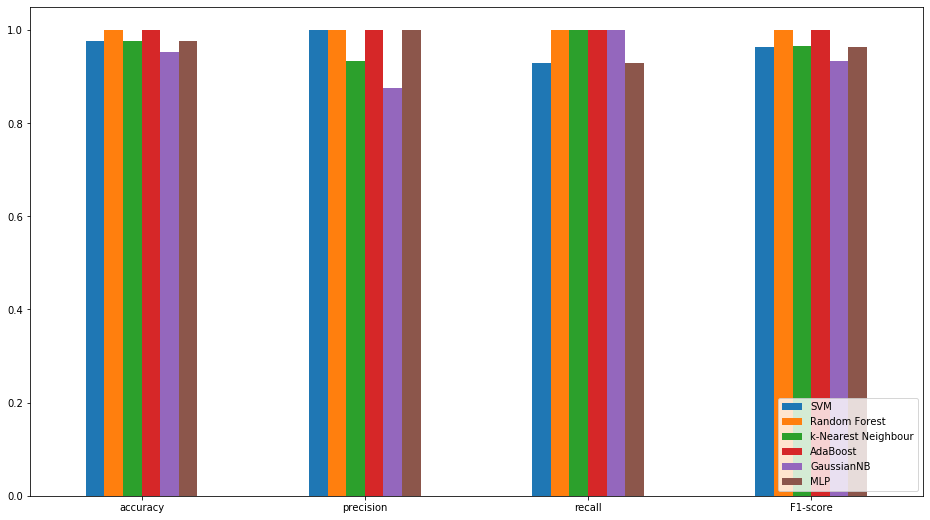

In [37]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KN_metrics = np.array([KN_accuracy, KN_precision, KN_recall, KN_f1_score])
AB_metrics = np.array([AB_accuracy, AB_precision, AB_recall, AB_f1_score])
GNB_metrics = np.array([GNB_accuracy, GNB_precision, GNB_recall, GNB_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])


%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'k-Nearest Neighbour': KN_metrics, 'AdaBoost': AB_metrics, 'GaussianNB': GNB_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

##### CV = 10
As can be seen from this run of the code, both the RF classifier and the AdaBoost classifier outperform all the other classifiers. However, SVM & MLPs' recall is not as good as the others.  

We could choose between RF or AdaBoost to train a final model on the whole dataset. These results will vary slightly when you run this notebook again. 

Ideally, the code could be enhanced to run the entire experiment multiple times and average the results.

We can also examine the ROC curves of the two classifiers for class 1.

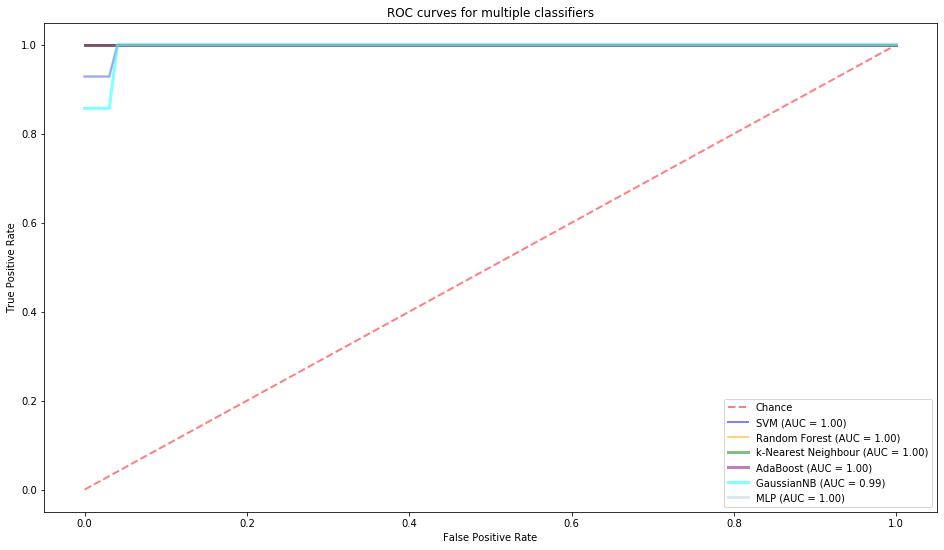

In [38]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.5)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='b', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.5)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.5)
plt.plot(mean_fpr, KN_tpr[0,:], lw=3, color='g', label='k-Nearest Neighbour (AUC = %0.2f)' % (KN_auc), alpha=0.5)
plt.plot(mean_fpr, AB_tpr[0,:], lw=3, color='purple', label='AdaBoost (AUC = %0.2f)' % (AB_auc), alpha=0.5)
plt.plot(mean_fpr, GNB_tpr[0,:], lw=3, color='cyan', label='GaussianNB (AUC = %0.2f)' % (GNB_auc), alpha=0.5)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=3, color='lightblue', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")

plt.show()

The ROC curves confirm that all classifiers perform significantly better than a random guess (the red dashed line) with all classifiers producing an AUC score of 1.00, except for GaussianNB (0.99).  

## Train a Final Model

Finally, we can train an RF model with all data we have, assuming that the more data we have the better the model.

In [52]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('rf__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, RandomForestClassifier(**transform(RF_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [53]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [54]:
pickle_in = open("final_model.sav","rb")
example = pickle.load(pickle_in)
print(example)

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('addcolumnnames',
                                  AddColumnNames(columns=['area', 'perimeter',
                                                          'compactness',
                                                          'length of kernel',
                                                          'width of kernel',
                                                          'asymmetry '
                                                          'coefficient',
                                                          'length of kernel '
                                                          'groove'])),
                                 ('featureunion',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('outlier_columns',
                                                               

In [55]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

1.0


In [56]:
predictions = final_model.predict(X_test)

In [57]:
predictions

array([1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
      dtype=int64)